In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json
import os
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm

import sys
import os


In [12]:
import sys
import os

import os
# print(os.getcwd())

sys.path.append(os.path.abspath('../Task 1'))
print(os.getcwd())
os.chdir('../Task1')
print(os.getcwd())
from task1 import WordPieceTokenizer

# Now you can use the WordPieceTokenizer class in your notebook
tokenizer = WordPieceTokenizer()

os.chdir('../Task2')
print(os.getcwd())


c:\Users\ISHITA\OneDrive\Desktop\CSAM6\NLP\Assignments\Assignment 1\Final Folder\Task2
c:\Users\ISHITA\OneDrive\Desktop\CSAM6\NLP\Assignments\Assignment 1\Final Folder\Task1
c:\Users\ISHITA\OneDrive\Desktop\CSAM6\NLP\Assignments\Assignment 1\Final Folder\Task2


## Word2VecDataset Class

In [13]:
# Word2VecDataset(Dataset) => inherits from the Dataset class of Pytorch
class Word2VecDataset(Dataset):
    
    def __init__(self, window_size):
        
        """
        text : input corput as string
        window size : defines how many words to take on either side as context
        pad token : a special token used for padding in case of insufficient context
        """

        # storing input parameters as instance variables
        self.text = None
        self.pad_token = '[PAD]'
        # print(self.text)
        self.window_size = window_size
        # creating an instance of word piece tokenizer
        self.tokenizer = WordPieceTokenizer()
        
        # containers

        # stores unique words in the corpus
        self.vocab = None
        # a dictionary mapping words to indices
        self.word2idx = None
        # a dictionary mapping indices to words
        self.idx2word = None
        # a list that will store training pairs
        self.cbow_pairs = []
        
        # this function tokenizes text, creates the vocabulary and generates CBOW training pairs
        self.preprocess_data()
        
    
    def tokenize_txt_file(self, input_file: str, output_file: str) -> None:
        """Tokenize sentences from input TXT file and save results as JSON"""
        
        # Reading the input text file
        with open(input_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        results = {}
        
        for idx, line in enumerate(lines):
            sentence = line.strip()  # Remove leading/trailing whitespaces or newlines
            tokens = self.tokenizer.tokenize(sentence)  # Tokenize the sentence using your tokenization method
            results[str(idx)] = tokens  # Store tokens with index as the key (starting from 0)
        
        # Saving the results to an output JSON file
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2)

    def preprocess_data(self):
        
        # tokenizes the input text into words using word piece tokenizer
        # words = self.tokenizer.tokenize(self.text)
        # words = self.text 

        # creates a sorted set of unique words, ensuring the padding token is included
        # unique_words = sorted(set(words) | {self.pad_token, self.unk_token})
        
        # # updates unique words
        # self.vocab.extend(word for word in unique_words if word not in self.vocab)

        print("getting vocab")
        self.tokenizer.construct_vocabulary("corpus.txt", vocab_size=100)

        vocabulary = []

        # Open the file in read mode
        with open('vocabulary_35.txt', 'r') as file:
            # Read each line from the file
            for line in file:
                # Remove any leading/trailing whitespaces and add to the vocabulary list
                word = line.strip()
                if word:  # Avoid adding empty lines
                    vocabulary.append(word)

        self.vocab = vocabulary
        print("got and updated vocab")

        print("tokenizing corpus")
        self.tokenize_txt_file("corpus.txt", "tokenized_corpus.json")

        corpus = None
        with open('tokenized_corpus.json', 'r', encoding='utf-8') as f:
            # Load the JSON data
            tokenized_corpus = json.load(f)
            
            # Convert the dictionary into a list of sentences (list of tokenized words)
            corpus = [tokens for tokens in tokenized_corpus.values()]
            
        
        self.text = corpus
        # print(corpus)

        # updates the word to index mapping
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        # updates the reverse index to word mapping
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        print("hey")
        # loops over all the  in the tokenized corpus
        for sentence in self.text:
            for j in range(len(sentence)):
                # Get context words within window
                context_words = (sentence[max(0, j - self.window_size):j] + 
                                sentence[j + 1:min(len(sentence), j + self.window_size + 1)])
                
                if len(context_words) > 0:
                    # Pad context if necessary
                    while len(context_words) < self.window_size * 2:
                        context_words.append(self.pad_token)
                    
                    # Convert context words and target words into numerical indices using self.word2idx
                    context_indices = [self.word2idx.get(w, self.word2idx[self.pad_token]) for w in context_words]
                    target_idx = self.word2idx.get(sentence[j], self.word2idx[self.pad_token])
                    
                    # Store the (context, target) pairs in self.cbow_pairs
                    self.cbow_pairs.append((context_indices, target_idx))

        '''for i, (context, target) in enumerate(self.cbow_pairs[:5]):
            print(f"Pair {i + 1}:")
            print(f"Context: {[self.idx2word[idx] for idx in context]}")
            print(f"Target: {self.idx2word[target]}")
            print("------")'''
        
    
    # returns the total number of CBOW training pairs
    def __len__(self):
        return len(self.cbow_pairs)
    
    # used to retrieve a single CBOW pair (context, target) pair
    def __getitem__(self, idx):

        # get the pair of ith index as mentioned parameter 
        context_indices, target_idx = self.cbow_pairs[idx]
        
        # Convert to tensors with explicit types
        context_tensor = torch.tensor(context_indices, dtype=torch.long)
        target_tensor = torch.tensor(target_idx, dtype=torch.long)
        
        return context_tensor, target_tensor



    


## Word2VecModel class

In [14]:
# Word2VecModel(nn.Module) => Inherits from nn.Module class in Pytorch

class Word2VecModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        
        '''
        vocab size : the size of the vocabulary
        embedding dimension : the number of features that represent each word
        '''

        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # creates a special table that stores word representations (called "embeddings") for each word in your vocabulary.
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        '''
        1. It projects the averaged context vector into a space of vocab_size dimensions
        2. The output represents raw scores (logits) for each word in the vocabulary
        3. These scores are typically passed through a softmax function to get probabilities
        4. The word with the highest probability is predicted as the target word
        '''

        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        
        # initialize weights
        self._initialize_weights()
    
    # function to initialize weights
    def _initialize_weights(self):
        
        # diving by embedding dimension as if the embeddings have more features then we would want weights to be scaled down to avoid large and unstable model.
        initrange = 0.5 / self.embedding_dim
        
        # initializes embedding layer weights with random values uniformly distributed in range as -
        self.embeddings.weight.data.uniform_(-initrange, initrange)
        
        # initializes output layer weights with random values uniformly distributed in range as -
        self.output_layer.weight.data.uniform_(-initrange, initrange)

        # initializing the bias of output layer = 0
        self.output_layer.bias.data.zero_()
    

    # function for forward pass of the model
    def forward(self, x: torch.Tensor):

        """
        x : input tensor, which represents the indices of the context words in the vocabulary. Its shape is [batch size, window size*2] -- [target word, [list of indexes of context words]]
        """

        # will look up for embeddings for each word in context and output list of embeddings of each congext word
        # size = [batch size, window size*2, embedding dimension]
        embedded = self.embeddings(x)
        
        # calculates average of context words... horizontally - row by row
        # size = [batch_size, embedding_dim]
        context_embedding = torch.mean(embedded, dim=1)
        
        # passing the average context embedding to output layer
        # output size vector = [batch_size, vocab_size]
        output = self.output_layer(context_embedding)

        # returning after application of softmax function
        return F.log_softmax(output, dim=1)



## Functions for saving and loading checkpoints

In [15]:
def save_checkpoint(model, checkpoint_path, epoch, optimizer, loss, accuracy):

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
        'vocab_size': model.vocab_size,
        'embedding_dim': model.embedding_dim,
        'timestamp': datetime.now().isoformat()
    }
    torch.save(checkpoint, checkpoint_path)


def load_checkpoint(model, checkpoint_path, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):

    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    return (
        model,
        checkpoint['optimizer_state_dict'],
        checkpoint['epoch'],
        checkpoint['loss']
    )

## Training Function

In [16]:

def train_word2vec(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    checkpoint_dir: str = 'checkpoints',
    save_frequency: int = 5,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
):
    """
    Train the Word2Vec model with mini-batch processing and checkpointing
    Now includes training accuracy tracking
    """
    # moves model to specified device (CPU or GPU)
    model.to(device)
    # optimizer for model's parameters along with learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # initializing the loss function
    criterion = nn.NLLLoss()
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Enhanced history dictionary to include accuracy
    history = {
        'epoch_losses': [],
        'epoch_accuracies': [],
        'batch_losses': [],
        'batch_accuracies': []
    }
    
    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        num_batches = len(train_loader)
        
        # Progress bar for batches
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        model.train()

        for batch_idx, (context, target) in enumerate(progress_bar):
            # Move data to device
            context = context.to(device)
            target = target.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            output = model.forward(context)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy for this batch
            predicted = output.argmax(dim=1)
            correct = (predicted == target).sum().item()
            total = target.size(0)
            
            batch_accuracy = (correct / total) * 100
            
            # Update metrics
            batch_loss = loss.item()
            epoch_loss += batch_loss
            epoch_correct += correct
            epoch_total += total
            
            history['batch_losses'].append(batch_loss)
            history['batch_accuracies'].append(batch_accuracy)
            
            # Update progress bar
            progress_bar.set_postfix({
                'batch_loss': f'{batch_loss:.4f}',
                'batch_acc': f'{batch_accuracy:.2f}%',
                'avg_loss': f'{epoch_loss/(batch_idx+1):.4f}'
            })
        
        # Calculate average epoch metrics
        avg_epoch_loss = epoch_loss / num_batches
        epoch_accuracy = (epoch_correct / epoch_total) * 100
        
        history['epoch_losses'].append(avg_epoch_loss)
        history['epoch_accuracies'].append(epoch_accuracy)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Average Loss: {avg_epoch_loss:.4f}')
        print(f'Training Accuracy: {epoch_accuracy:.2f}%')

        print("\nValidating model...")
        val_loss, accuracy = validate_model(model, val_loader, device)
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.2f}%")
        
        
        # Save checkpoint
        if (epoch + 1) % save_frequency == 0:
            checkpoint_path = os.path.join(
                checkpoint_dir,
                f'word2vec_checkpoint_epoch_{epoch+1}.pt'
            )
            save_checkpoint(
                model,
                checkpoint_path,
                epoch,
                optimizer,
                avg_epoch_loss,
                epoch_accuracy  # Added accuracy to checkpoint
            )
            print(f'Checkpoint saved: {checkpoint_path}')
    
    # Save final model
    final_checkpoint_path = os.path.join(checkpoint_dir, 'word2vec_final_model.pt')
    save_checkpoint(
        model,
        final_checkpoint_path,
        num_epochs-1,
        optimizer,
        history['epoch_losses'][-1],
        history['epoch_accuracies'][-1]
    )
    
    print(f'Final model saved: {final_checkpoint_path}')
    return history




## Evaluation Functions

In [ ]:


def validate_model(model: nn.Module, val_loader: DataLoader, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    criterion = nn.NLLLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    num_batches = len(val_loader)
    
    with torch.no_grad():
        for context, target in val_loader:
            context = context.to(device)
            target = target.to(device)
            
            # Forward pass
            output = model(context)
            loss = criterion(output, target)
            
            # Calculate loss
            total_loss += loss.item()
            
            # Calculate accuracy
            predicted = output.argmax(dim=1)
            total_correct += (predicted == target).sum().item()
            total_samples += target.size(0)
    
    # Calculate average metrics
    avg_loss = total_loss / num_batches
    accuracy = (total_correct / total_samples) * 100
    
    return avg_loss, accuracy


def evaluate_model(model, val_loader, device, dataset, BATCH_SIZE) :
    model.eval()
    
    with torch.no_grad():
        for i, (context, target) in enumerate(val_loader):
            context = context.to(device)
            target = target.to(device)
            
            # Get model prediction
            output = model(context)
            predicted_indices = output.argmax(dim=1)
            
            # Convert to words
            for j in range(len(context)):
                context_words = [dataset.idx2word[idx.item()] for idx in context[j]]
                true_word = dataset.idx2word[target[j].item()]
                predicted_word = dataset.idx2word[predicted_indices[j].item()]
                
                print(f"\nPair {i*BATCH_SIZE + j + 1}:")
                print(f"Context: {context_words}")
                print(f"True word: {true_word}")
                print(f"Predicted: {predicted_word}")
                print(f"Correct: {'✓' if true_word == predicted_word else '✗'}")
            
            # Print only first 5 validation pairs for brevity
            if i >= 4:
                print("\n... (showing first 20 pairs only)")
                break

def plot_training_history(history):
    """Plot both training loss and accuracy over epochs"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['epoch_losses'], label='Training Loss')
    ax1.set_title('Training Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['epoch_accuracies'], label='Training Accuracy', color='green')
    ax2.set_title('Training Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## Saving Model

In [17]:
def save_model(final_model_dir, model, val_loss, accuracy):
    model_path = os.path.join(final_model_dir, 'final_model.pt')
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab_size': model.vocab_size,
        'embedding_dim': model.embedding_dim,
        'val_loss': val_loss,
        'val_accuracy': accuracy
    }, model_path)


def save_vocabulary(final_model_dir, dataset):   
    vocab_path = os.path.join(final_model_dir, 'vocabulary.json')
    vocab_data = {
        'word2idx': dataset.word2idx,
        'idx2word': dataset.idx2word
    }
    with open(vocab_path, 'w') as f:
        json.dump(vocab_data, f)

## Main Function

Creating dataset...
getting vocab
got and updated vocab
tokenizing corpus
hey

Vocabulary Size: 100
Total Pairs: 185769
Training Pairs: 148615
Validation Pairs: 37154

Sample vocabulary items: ['##a', '##b', '##bj', '##c', '##d']

Initializing model...

Starting training...


Epoch 1/1: 100%|██████████| 1162/1162 [00:09<00:00, 118.61it/s, batch_loss=2.9466, batch_acc=14.29%, avg_loss=2.8395]



Epoch 1/1:
Average Loss: 2.8395
Training Accuracy: 23.49%

Validating model...
Validation Loss: 2.5857
Validation Accuracy: 27.00%
Final model saved: word2vec_checkpoints\word2vec_final_model.pt

Validating model...
Validation Loss: 2.5857
Validation Accuracy: 27.00%


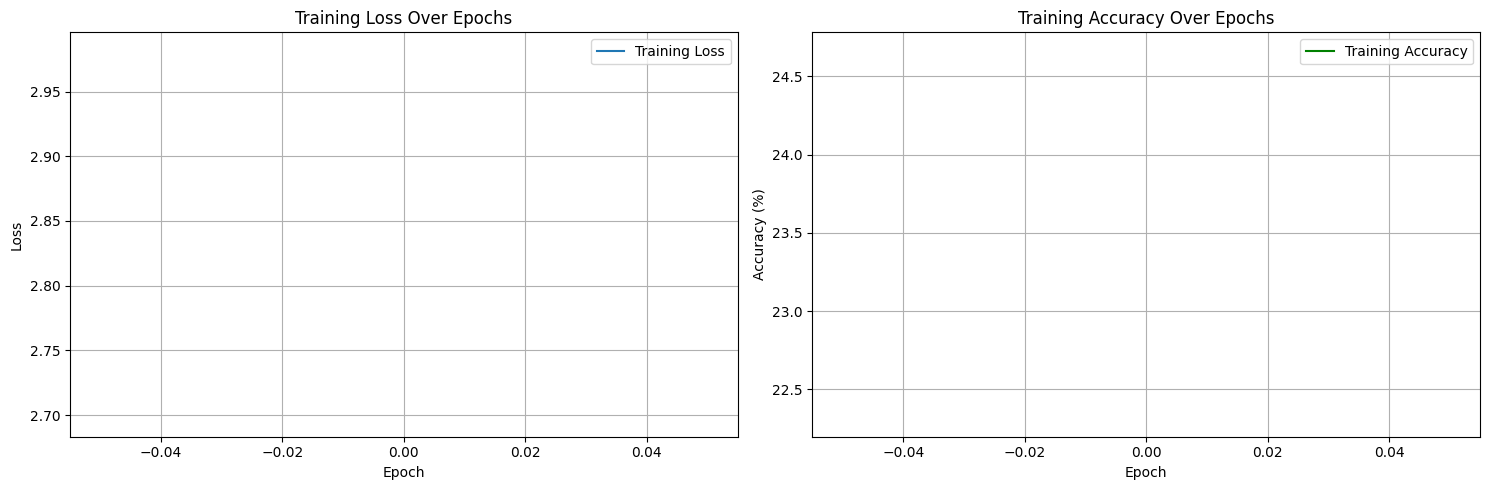


Validation Pairs vs Predictions:
--------------------------------------------------

Pair 1:
Context: ['##t', '##n']
True word: ##a
Predicted: ##i
Correct: ✗

Pair 2:
Context: ['i', '##p']
True word: ##m
Predicted: ##m
Correct: ✓

Pair 3:
Context: ['##o', 'a']
True word: ##r
Predicted: ##n
Correct: ✗

Pair 4:
Context: ['##p', 'a']
True word: up
Predicted: ##m
Correct: ✗

Pair 5:
Context: ['##d', 'f']
True word: i
Predicted: ##e
Correct: ✗

Pair 6:
Context: ['##l', '##n']
True word: ##i
Predicted: ##i
Correct: ✓

Pair 7:
Context: ['##n', '##e']
True word: w
Predicted: ##d
Correct: ✗

Pair 8:
Context: ['##i', '##g']
True word: ##n
Predicted: ##n
Correct: ✓

Pair 9:
Context: ['##i', '##e']
True word: ##k
Predicted: ##l
Correct: ✗

Pair 10:
Context: ['m', '##m']
True word: ##e
Predicted: ##e
Correct: ✓

Pair 11:
Context: ['##e', '##y']
True word: ##r
Predicted: m
Correct: ✗

Pair 12:
Context: ['m', '##r']
True word: ##o
Predicted: ##e
Correct: ✗

Pair 13:
Context: ['th', 'f']
True word: #

In [19]:
def main():

    WINDOW_SIZE = 1
    EMBEDDING_DIM = 150
    BATCH_SIZE = 128
    NUM_EPOCHS = 1
    LEARNING_RATE = 0.002
    TRAIN_SPLIT = 0.8
    
    # Create dataset
    print("Creating dataset...")
    dataset = Word2VecDataset(window_size=WINDOW_SIZE)
    

    # Split dataset into training and validation
    train_size = int(TRAIN_SPLIT * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Print dataset information
    print(f"\nVocabulary Size: {len(dataset.vocab)}")
    print(f"Total Pairs: {len(dataset)}")
    print(f"Training Pairs: {len(train_dataset)}")
    print(f"Validation Pairs: {len(val_dataset)}")
    print("\nSample vocabulary items:", list(dataset.vocab)[:5])
    
    # Create model and set device
    print("\nInitializing model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Word2VecModel(
        vocab_size=len(dataset.vocab),
        embedding_dim=EMBEDDING_DIM
    ).to(device)
    
    # Train model
    print("\nStarting training...")

    history = train_word2vec(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        checkpoint_dir='word2vec_checkpoints',
        save_frequency=2
    )
    
    # Validate model and get accuracy
    print("\nValidating model...")
    val_loss, accuracy = validate_model(model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")
    
    # Plot training history
    plot_training_history(history)
    
    # Print validation pairs and predictions
    print("\nValidation Pairs vs Predictions:")
    print("-" * 50)

    evaluate_model(model, val_loader, device, dataset, BATCH_SIZE)
    
    # Save final model and vocabulary
    print("\nSaving final model and vocabulary...")
    final_model_dir = 'final_model'
    os.makedirs(final_model_dir, exist_ok=True)
    
    # Save vocabulary
    save_vocabulary(final_model_dir, dataset)
    
    # Save final model state
    save_model(final_model_dir, model, val_loss, accuracy)



if __name__ == "__main__":
    main()